<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/dots/dots_Silhouette_validation_DINOV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import silhouette_score
import torchvision.transforms as T
import timm

# === 1. טעינת מודל DINOv2 קטן (ViT-B/14) דרך timm ===
dinov2_model = timm.create_model('vit_base_patch14_dinov2', pretrained=True, num_classes=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dinov2_model.to(device).eval()

# === 2. הגדרת טרנספורמציות ===
# טרנספורמציה בסיסית של המודל
data_config = timm.data.resolve_model_data_config(dinov2_model)
default_transform = timm.data.create_transform(**data_config, is_training=False)

class PadToCenter224:
    def __call__(self, img):
        w, h = img.size
        scale = min(224 / w, 224 / h, 1.0)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        canvas = Image.new("RGB", (224, 224))
        canvas.paste(img, ((224 - new_w) // 2, (224 - new_h) // 2))
        return default_transform(canvas)

def resize_and_pad(size):
    class ResizeAndPad:
        def __call__(self, img):
            img = img.resize((size, size), Image.BICUBIC)
            canvas = Image.new("RGB", (224, 224))
            canvas.paste(img, ((224 - size) // 2, (224 - size) // 2))
            return default_transform(canvas)
    return ResizeAndPad()

class Duplicate2x2Grid:
    def __call__(self, img):
        w, h = img.size
        grid = Image.new("RGB", (w * 2, h * 2))
        for i in range(2):
            for j in range(2):
                grid.paste(img, (i * w, j * h))
        return default_transform(grid.resize((224, 224), Image.BICUBIC))

transforms_dict = {
    "pad_center_224": PadToCenter224(),
    "resize_224": default_transform,
    "resize_50_pad": resize_and_pad(50),
    "resize_100_pad": resize_and_pad(100),
    "resize_150_pad": resize_and_pad(150),
    "resize_200_pad": resize_and_pad(200),
    "grid_2x2": Duplicate2x2Grid(),
}

# === 3. פונקציות עזר ===
def get_image_paths(dirpath):
    out = []
    for cl in os.listdir(dirpath):
        cp = os.path.join(dirpath, cl)
        if os.path.isdir(cp):
            out += [os.path.join(cp, f)
                    for f in os.listdir(cp)
                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    return out

def extract_embeddings(paths, transform):
    X, y = [], []
    with torch.no_grad():
        for p in tqdm(paths):
            img = Image.open(p).convert("RGB")
            tensor_img = transform(img).unsqueeze(0).to(device)
            feats = dinov2_model.forward_features(tensor_img)
            pooled = dinov2_model.forward_head(feats, pre_logits=True)
            X.append(pooled.squeeze().cpu().numpy())
            y.append(os.path.basename(os.path.dirname(p)))
    return np.array(X), np.array(y)

def compute_sep(X, y):
    centroids = [X[y == c].mean(0) for c in np.unique(y)]
    dists = [np.linalg.norm(centroids[i] - centroids[j])
             for i in range(len(centroids))
             for j in range(i)]
    return np.mean(dists)

# === 4. הרצת טרנספורמציות והפקת תוצאות ===
train_paths = get_image_paths("/content/drive/MyDrive/dots_data_new/train")
results_train = []
train_embeddings = {}

for name, tf in transforms_dict.items():
    print(f"\n🔄 Processing transform: {name}")
    X, y = extract_embeddings(train_paths, tf)
    train_embeddings[name] = (X, y)
    sil = silhouette_score(X, y)
    sep = compute_sep(X, y)
    results_train.append({"Transform": name, "Silhouette": sil, "Separation": sep})

df_train = pd.DataFrame(results_train).sort_values(by="Silhouette", ascending=False)
print("\n📊 Training Metrics:")
print(df_train.to_string(index=False, float_format="%.3f"))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


🔄 Processing transform: pad_center_224


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]



🔄 Processing transform: resize_224


100%|██████████| 12/12 [00:01<00:00, 10.44it/s]



🔄 Processing transform: resize_50_pad


100%|██████████| 12/12 [00:01<00:00, 10.55it/s]



🔄 Processing transform: resize_100_pad


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



🔄 Processing transform: resize_150_pad


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



🔄 Processing transform: resize_200_pad


100%|██████████| 12/12 [00:01<00:00, 10.68it/s]



🔄 Processing transform: grid_2x2


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



📊 Training Metrics:
     Transform  Silhouette  Separation
pad_center_224       0.409      37.126
 resize_50_pad       0.385      36.150
resize_100_pad       0.374      38.738
resize_150_pad       0.356      39.270
    resize_224       0.342      39.071
resize_200_pad       0.341      39.141
      grid_2x2       0.335      38.001


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

# בחר את השם של ההכנה שאתה רוצה לבדוק
chosen_transform_name = "resize_150_pad"  # <-- שנה כאן לפי הצורך

# הגדר מודלים ופרמטרים
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}),
    "NaiveBayes": (GaussianNB(), {})
}

# טען נתוני אימון והמר labels
X_train, y_train = train_embeddings[chosen_transform_name]
val_paths = get_image_paths("/content/drive/MyDrive/dots_data_new/validation")
X_val, y_val = extract_embeddings(val_paths, transforms_dict[chosen_transform_name])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

val_results = []
best_params = {}

print(f"\nRunning validation for transform: {chosen_transform_name}")
for clf_name, (clf, grid) in classifiers.items():
    if grid:
        gs = GridSearchCV(clf, grid, cv=3, scoring="accuracy")
        gs.fit(X_train, y_train_enc)
        best = gs.best_estimator_
        best_params[clf_name] = gs.best_params_
    else:
        best = clf.fit(X_train, y_train_enc)
        best_params[clf_name] = {}

    y_pred = best.predict(X_val)
    acc = accuracy_score(y_val_enc, y_pred)
    min_cls = np.bincount(y_val_enc).argmin()
    f1_min = f1_score(y_val_enc, y_pred, labels=[min_cls], average="macro")

    val_results.append({
        "Model": clf_name,
        "Accuracy": acc,
        "F1_Minority": f1_min
    })

# הצגת טבלה מסכמת
df_val = pd.DataFrame(val_results)
df_val.set_index("Model", inplace=True)
print("\nValidation Results for transform:", chosen_transform_name)
print(df_val.round(3).to_string())

# הדפסת הפרמטרים האופטימליים
print("\nBest hyperparameters:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]



Running validation for transform: resize_150_pad

Validation Results for transform: resize_150_pad
                    Accuracy  F1_Minority
Model                                    
LogisticRegression     0.941        0.941
SVM                    1.000        1.000
RandomForest           0.824        0.824
NaiveBayes             0.647        0.727

Best hyperparameters:
LogisticRegression: {'C': 0.01, 'penalty': 'l2'}
SVM: {'C': 0.1, 'gamma': 'scale'}
RandomForest: {'max_depth': None, 'n_estimators': 50}
NaiveBayes: {}


In [ ]:
def visualize_predictions_with_bboxes(full_image_path, file_paths, predicted_labels, save_path):
    """
    מציירת תיבות סביב האובייקטים בתמונה לפי התחזיות של המודל.

    Parameters:
    - full_image_path: str, הנתיב לתמונה המלאה (background)
    - file_paths: list of str, מסלולים לתמונות החתוכות (שמות כוללים קואורדינטות)
    - predicted_labels: list of str/int, התחזיות (labels) של המודל
    - save_path: str, הנתיב לשמירת התמונה עם התיבות
    """
    import cv2
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    full_image = cv2.imread(full_image_path)
    image_copy = full_image.copy()
    pattern = re.compile(r"dots_test_(\d+)_(\d+)_(\d+)_(\d+)\.jpg")

    unique_labels = list(set(predicted_labels))
    colors = {}

    color_palette = [
        (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
        (255, 0, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0),
    ]

    for i, label in enumerate(unique_labels):
        colors[label] = color_palette[i % len(color_palette)]

    legend_height = 30 * len(unique_labels)
    legend_width = 200
    legend_img = np.ones((legend_height, legend_width, 3), dtype=np.uint8) * 255

    for i, label in enumerate(unique_labels):
        color = colors[label]
        cv2.rectangle(legend_img, (10, i*30 + 10), (30, i*30 + 30), color, -1)
        cv2.putText(legend_img, f"Class {label}", (40, i*30 + 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    for file_path, label in zip(file_paths, predicted_labels):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            x1, y1, x2, y2 = map(int, match.groups())
            color = colors[label]
            overlay = image_copy.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 1)
            alpha = 1.4
            cv2.addWeighted(overlay, alpha, image_copy, 1 - alpha, 0, image_copy)

    cv2.imwrite(save_path, image_copy)
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    legend_rgb = cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]})
    ax[0].imshow(image_rgb)
    ax[0].set_title("Image with Bounding Boxes")
    ax[0].axis('off')

    ax[1].imshow(legend_rgb)
    ax[1].set_title("Class Legend")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Saved image with bounding boxes to: {save_path}")


In [ ]:
def evaluate_on_test(transform_name, model_name):
    tf = transforms_dict[transform_name]
    X_train, y_train = train_embeddings[transform_name]
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)

    clf, _grid = classifiers[model_name]
    params = best_params.get((transform_name, model_name), {})
    clf.set_params(**params)
    clf.fit(X_train, y_train_enc)

    # test embeddings
    test_paths = get_image_paths("/content/drive/MyDrive/dots_data_new/test")
    X_test, y_test = extract_embeddings(test_paths, tf)
    y_test_enc = le.transform(y_test)

    # Predictions
    y_pred = clf.predict(X_test)

        # לאחר חישוב y_pred:
    y_pred_labels = le.inverse_transform(y_pred)

    # קריאה לפונקציית ההדמיה הנפרדת
    visualize_predictions_with_bboxes(
        full_image_path="/content/drive/MyDrive/pictures_data/dots_test.jpg",
        file_paths=test_paths,
        predicted_labels=y_pred_labels,
        save_path=f"/content/drive/MyDrive/bboxes_dots_{model_name}_{transform_name}.jpg"
    )


    # Confusion Matrix
    cm = confusion_matrix(y_test_enc, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    plt.figure(figsize=(6,5))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Test Confusion Matrix\n{model_name} | {transform_name}")
    plt.tight_layout()
    plt.show()

    # Classification Report
    report = classification_report(y_test_enc, y_pred, target_names=le.classes_)
    print(f"\nClassification Report for {model_name} | {transform_name}:\n")
    print(report)

    return {
    "test_paths": test_paths,
    "y_pred": y_pred,
    "le": le
    }

100%|██████████| 118/118 [00:11<00:00, 10.31it/s]


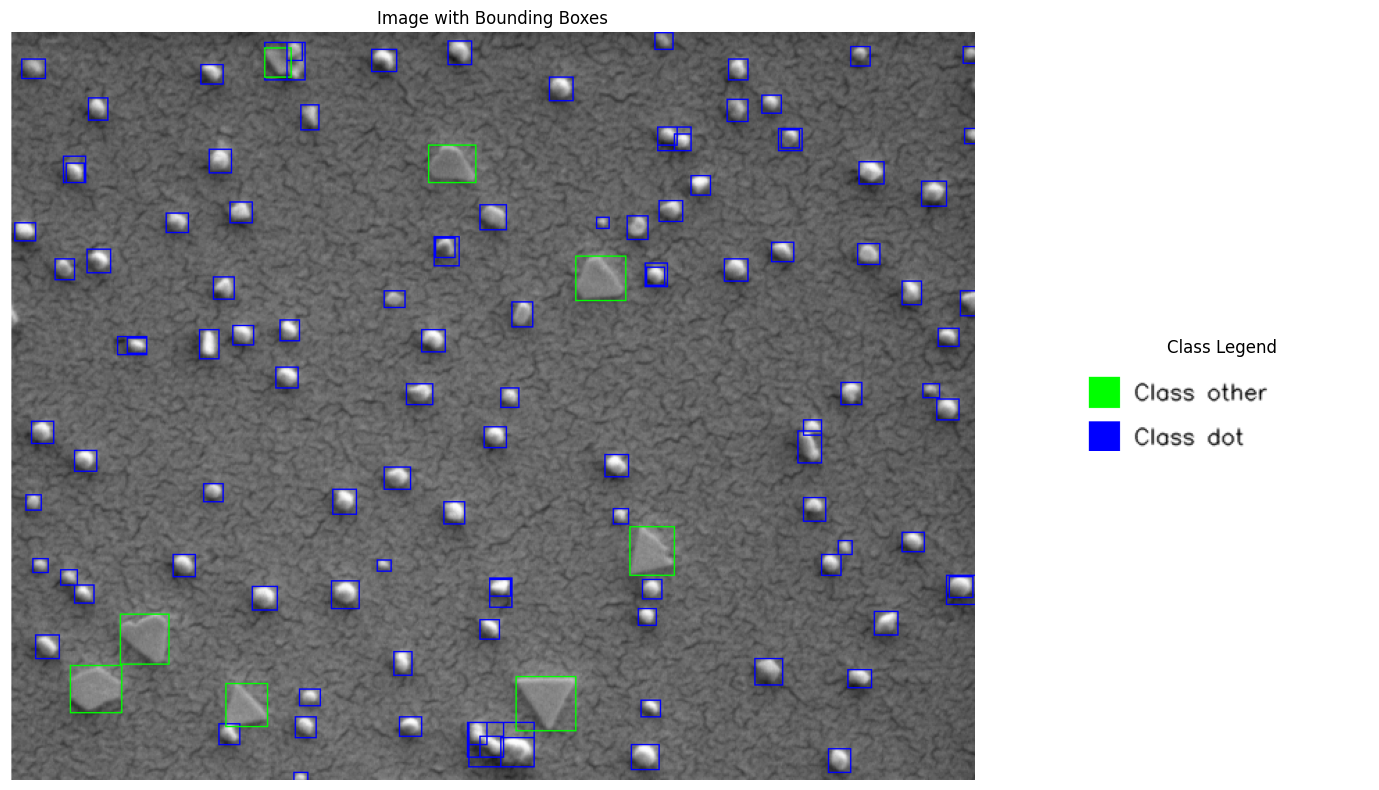

Saved image with bounding boxes to: /content/drive/MyDrive/bboxes_dots_SVM_resize_150_pad.jpg


<Figure size 600x500 with 0 Axes>

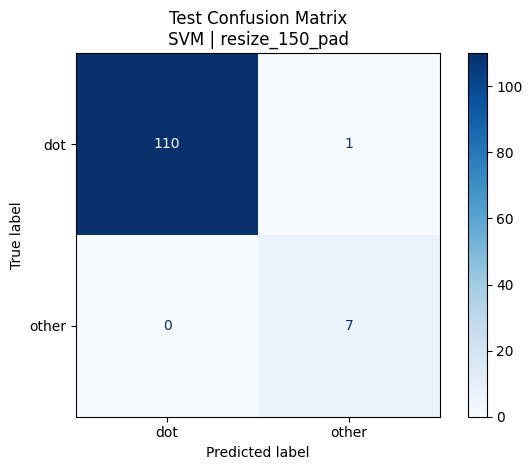


Classification Report for SVM | resize_150_pad:

              precision    recall  f1-score   support

         dot       1.00      0.99      1.00       111
       other       0.88      1.00      0.93         7

    accuracy                           0.99       118
   macro avg       0.94      1.00      0.96       118
weighted avg       0.99      0.99      0.99       118



AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
results = evaluate_on_test("resize_150_pad", "SVM")

visualize_predictions_with_bboxes(
    full_image_path="drive/MyDrive/dots_test.jpg",
    save_path="drive/MyDrive/full_image_with_bboxes_dots.jpg",
    file_paths=results["test_paths"],
    predicted_labels=results["le"].inverse_transform(results["y_pred"])
)